<a href="https://colab.research.google.com/github/bild12/EspIA/blob/Proyectos/BD_2_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo sumativo de Proyecto de Aplicación Esp-IA

**Título del trabajo:**  Ciclo-3A

---

## Integrantes

| Nombre Completo     | Correo                   |
|---------------------|--------------------------|
| Nicolas José Trujillo Barros       | Nicolas-Trujillob@Javeriana.Edu.co​      |
| Julián David Pava Quinguirejo       | Julian.Pava@Javeriana.Edu.co​    |
| Bibiana Ivette Lopez Dominguez        | Lopezdbi@Javeriana.Edu.co​   |

---

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 41.1 MB/s eta 0:00:00


In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4e02f9bd458e459f64b0f7ca8e33d87394c0bd7af78d096ca7a295e15654cf91
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.5 MB/s eta 0:00:00


In [ ]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 12.9 MB/s eta 0:00:00


In [ ]:
import fitz
from google.colab import drive
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from langdetect import detect
import pandas as pd
from collections import Counter
from datetime import datetime
import seaborn as sns
import gdown
import unicodedata
import zipfile
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
import faiss
import random


### Carga de stopwords en inglés

Se descargan y cargan las *stopwords* del idioma inglés utilizando la biblioteca NLTK.  
Estas palabras vacías, como "the", "is", "and", "at", etc., son comunes en el lenguaje pero no aportan significado relevante en tareas de análisis de texto.  
Por esta razón, se eliminarán más adelante del texto procesado para mejorar la calidad de los resultados al extraer habilidades.


In [ ]:
nltk.download('stopwords')
stopwords_en = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 ### Carga y combinación de habilidades desde dos fuentes

Este bloque de código carga y combina habilidades desde dos conjuntos de datos:

1. **ESCO**: Se cargan habilidades del archivo `skills_en.csv`, filtrando solo aquellas etiquetadas como `skill/competence` y extrayendo la columna `preferredLabel` en minúsculas para normalizar.

2. **Stack Overflow Developer Survey**: Se extraen habilidades técnicas desde varias columnas del archivo `survey_results_public.csv`, correspondientes a tecnologías usadas por los desarrolladores. Las habilidades se dividen por el delimitador `;`, se limpian y se convierten a minúsculas.

Finalmente, ambas listas de habilidades (ESCO y Stack Overflow) se combinan en un solo conjunto sin duplicados, creando un vocabulario más amplio y representativo para analizar los CVs.


In [ ]:
# ========== 1. CARGAR HABILIDADES ==========
# Cargamos el conjunto de datos
file_id = "1aMpYZoJtbAiSkXRiQgN3Z7yfzPVJwUwK"
url = f"https://drive.google.com/uc?id={file_id}"
output = "skills_en.csv"
gdown.download(url, output, quiet=False)

df_skills = pd.read_csv("skills_en.csv")
df_skills = df_skills[df_skills['skillType'] == 'skill/competence']
lista_habilidades_ESCO = df_skills['preferredLabel'].dropna().str.lower().unique().tolist()

file_id = "15LMn150RSTi2ymchNrZ4X0Z__3nwWsjC"
url = f"https://drive.google.com/uc?id={file_id}"
output = "survey_results_public.csv"
gdown.download(url, output, quiet=False)

df_so = pd.read_csv("survey_results_public.csv")
cols_so_skills = [
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
    'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith',
    'ToolsTechHaveWorkedWith', 'PlatformHaveWorkedWith'
]
stack_skills = set()
for col in cols_so_skills:
    if col in df_so.columns:
        df_so[col] = df_so[col].fillna("")
        for lista in df_so[col]:
            for skill in str(lista).split(";"):
                skill = skill.strip().lower()
                if skill:
                    stack_skills.add(skill)

lista_stack_skills = list(stack_skills)
habilidades_extra = [
    'qlik', 'boomi', 'business objects', 'hyperion', 'business objects data services',
    'google big query', 'hana', 'convergent mediation', 'power bi', 'tableau', 'lookml',
    'looker', 'datastage', 'informatica', 'sap bw', 'sap hana', 'aws redshift', 'azure data factory',
    'snowflake', 'teradata', 'cognos', 'ssis', 'ssrs', 'airflow', 'dbt', 'sap business objects',
    'bigquery', 'salesforce', 'workday', 'netsuite', 'microstrategy', 'oracle bi', 'alteryx',
    'sap analytics cloud', 'gcp', 'azure', 'aws', 'kubernetes', 'docker', 'spark', 'hadoop',
    'revenue recognition', 'p&l', 'margin analysis', 'financial principles', 'financial analysis',
    'data analysis', 'microsoft excel', 'excel', 'data analytics',
    'conflict management', 'resilience', 'adaptability', 'negotiation', 'communication skills'
]

# Unir todo
lista_habilidades = list(
    set(lista_habilidades_ESCO + lista_stack_skills + habilidades_extra)
)
print(f"Total de habilidades combinadas: {len(lista_habilidades)}")

Downloading...
From: https://drive.google.com/uc?id=1aMpYZoJtbAiSkXRiQgN3Z7yfzPVJwUwK
To: /content/skills_en.csv
100%|██████████| 9.28M/9.28M [00:00<00:00, 38.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=15LMn150RSTi2ymchNrZ4X0Z__3nwWsjC
From (redirected): https://drive.google.com/uc?id=15LMn150RSTi2ymchNrZ4X0Z__3nwWsjC&confirm=t&uuid=460b93c4-5560-4d67-8973-f25035e0098f
To: /content/survey_results_public.csv
100%|██████████| 160M/160M [00:02<00:00, 65.6MB/s]


Total de habilidades combinadas: 10984


### Funciones auxiliares para el procesamiento de CVs

Este bloque define un conjunto de funciones utilizadas para procesar y analizar los currículums en formato PDF:

1. **`extraer_texto_pdf(ruta_pdf)`**  
   Abre un archivo PDF y extrae el texto de todas sus páginas usando la biblioteca `fitz` (PyMuPDF).

2. **`limpiar_texto(texto)`**  
   Convierte el texto a minúsculas, elimina números, puntuación y stopwords del idioma inglés. Esto facilita la comparación y búsqueda de habilidades dentro del contenido textual.

3. **`extraer_habilidades(texto, lista_habilidades)`**  
   Recorre la lista de habilidades proporcionada y utiliza expresiones regulares para buscar coincidencias exactas dentro del texto limpio del CV.

4. **`extraer_experiencia_total(texto)`**  
   Estima la experiencia total en años a partir del texto. Utiliza dos enfoques:
   - Busca expresiones directas como “X years of experience”.
   - Extrae fechas y calcula rangos de años entre pares consecutivos, considerando también frases como “to present” o “to current”.

5. **`clasificar_seniority(experiencia, habilidades)`**  
   Asigna un nivel de seniority al perfil en función de la experiencia en años y la cantidad de habilidades detectadas. Las categorías incluyen: Senior, SemiSenior, Junior, Profesional sin experiencia y Sin clasificar.


In [ ]:
# ========== 2. FUNCIONES ==========
def extraer_texto_pdf(ruta_pdf):
    doc = fitz.open(ruta_pdf)
    texto_completo = ""
    for pagina in doc:
        texto_completo += pagina.get_text()
    doc.close()
    return texto_completo

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    tokens = texto.split()
    return " ".join([t for t in tokens if t not in stopwords_en])

def extraer_habilidades(texto, lista_habilidades):
    texto = texto.lower()
    habilidades_detectadas = []
    for habilidad in lista_habilidades:
        if re.search(rf'\b{re.escape(habilidad)}\b', texto):
            habilidades_detectadas.append(habilidad)
    return habilidades_detectadas


from datetime import datetime
import re

def extraer_experiencia_total(texto):
    texto = texto.lower()
    anios_detectados = []

    # 1. Buscar menciones explícitas como "10 years of experience"
    patrones = [
        r"(\d+)\s+years?\s+of\s+experience",
        r"experience\s+of\s+(\d+)\s+years",
        r"worked\s+for\s+(\d+)\s+years",
        r"more\s+than\s+(\d+)\s+years",
        r"(\d+)\s+years?\s+experience"
    ]

    for patron in patrones:
        matches = re.findall(patron, texto)
        for match in matches:
            try:
                anios_detectados.append(int(match))
            except:
                pass

    # 2. Buscar fechas tipo MM/YYYY o YYYY (en pares)
    fecha_patron = r"(0[1-9]|1[0-2])\/(\d{4})|\b(\d{4})\b"
    fechas = re.findall(fecha_patron, texto)
    años_limpios = []

    for match in fechas:
        año = match[1] or match[2]
        try:
            año = int(año)
            if 1950 < año <= datetime.now().year:
                años_limpios.append(año)
        except:
            continue

    # Agrupar en pares año_inicio -> año_fin y sumar diferencias
    años_limpios.sort()
    experiencia_rangos = 0
    for i in range(0, len(años_limpios) - 1, 2):
        inicio = años_limpios[i]
        fin = años_limpios[i + 1]
        if fin >= inicio:
            experiencia_rangos += fin - inicio

    # Considerar también "to current", "to present"
    actuales = re.findall(r"(\d{4})\s+(to\s+(present|current))", texto)
    for match in actuales:
        try:
            inicio = int(match[0])
            fin = datetime.now().year
            if fin >= inicio:
                experiencia_rangos += fin - inicio
        except:
            continue

    # === 3. Detectar si es pasantía o nivel de entrada ===
    palabras_clave_no_experiencia = ['intern', 'entry level', 'graduate program', 'trainee']
    if any(re.search(rf'\b{re.escape(palabra)}\b', texto) for palabra in palabras_clave_no_experiencia):
        return 0

    # === 4. Combinar todo lo detectado ===
    total_experiencia = max(anios_detectados + [experiencia_rangos]) if (anios_detectados or experiencia_rangos > 0) else 0

    # === 5. Detectar si sugiere seniority en caso de que todo sea 0 ===
    if total_experiencia == 0:
      palabras_clave_senior = ['senior', 'architect', 'lead', 'expert', 'principal', 'director']
      if any(re.search(rf'\b{re.escape(palabra)}\b', texto) for palabra in palabras_clave_senior):
          total_experiencia = 5

    return total_experiencia



def clasificar_seniority(experiencia, habilidades):
    if (experiencia >= 5) or (experiencia >= 4 and habilidades >= 8):
        return "Senior"
    elif (experiencia >= 2 and habilidades >= 4):
        return "SemiSenior"
    elif (experiencia >= 1) or (habilidades >= 3):
        return "Junior"
    elif (experiencia == 0 and habilidades > 0):
        return "Profesional sin experiencia"
    else:
        return "Sin clasificar"


### Procesamiento de CVs desde archivos PDF

Este bloque de código recorre todos los archivos PDF ubicados en una carpeta específica, extrae información relevante de cada uno y genera una estructura con los resultados.

**Pasos que realiza:**

1. **Verificación de la carpeta:**  
   Comprueba que la carpeta especificada exista y sea válida.

2. **Recorrido de archivos PDF:**  
   Itera sobre todos los archivos PDF encontrados en la carpeta.

3. **Extracción y limpieza de texto:**  
   Utiliza las funciones definidas previamente para:
   - Extraer el texto del PDF.
   - Limpiar el texto eliminando stopwords, puntuación, etc.

4. **Extracción de habilidades y experiencia:**  
   - Detecta habilidades listadas en el CV basadas en un listado predefinido.
   - Estima los años de experiencia a partir del texto original.

5. **Clasificación de seniority:**  
   - Aplica reglas heurísticas para asignar un nivel de seniority (Junior, SemiSenior, Senior, etc.).

6. **Construcción del dataset:**  
   - Guarda en una lista de resultados la siguiente información por CV:
     - Nombre del archivo.
     - Número de habilidades detectadas.
     - Habilidades encontradas.
     - Experiencia total estimada en años.
     - Nivel de seniority asignado.

7. **Concatenación de habilidades:**  
   - Todas las habilidades detectadas se acumulan en una sola cadena para su análisis posterior, por ejemplo para visualización con nubes de palabras.


In [ ]:
# ========== 3. PROCESAR CVS ==========
file_id = "1ueU6Mw7MGZOUmxyl4KjFEvYvaUXScuIP"
url = f"https://drive.google.com/uc?id={file_id}"
output = "hojas_de_vida_developers.zip"

gdown.download(url, output, quiet=False)

# === 2. Extraer el ZIP ===
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("hojas_de_vida_developers")

carpeta = "hojas_de_vida_developers/hojas_de_vida_developers/"
texto_total = ""
resultados = []

if os.path.exists(carpeta) and os.path.isdir(carpeta):
    print(f" Carpeta encontrada: {carpeta}")
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(".pdf"):
            ruta_completa = os.path.join(carpeta, archivo)
            texto_extraido = extraer_texto_pdf(ruta_completa)
            texto_limpio = limpiar_texto(texto_extraido)

            habilidades_encontradas = extraer_habilidades(texto_limpio, lista_habilidades)
            experiencia_total = extraer_experiencia_total(texto_extraido)
            seniority = clasificar_seniority(experiencia_total, len(habilidades_encontradas))

            texto_total += " " + " ".join(habilidades_encontradas)

            resultados.append({
                "archivo": archivo,
                "n_habilidades": len(habilidades_encontradas),
                "habilidades": ", ".join(habilidades_encontradas),
                "experiencia_total_anios": experiencia_total,
                "seniority": seniority
            })
else:
    print(" La carpeta no existe:", carpeta)

Downloading...
From: https://drive.google.com/uc?id=1ueU6Mw7MGZOUmxyl4KjFEvYvaUXScuIP
To: /content/hojas_de_vida_developers.zip
100%|██████████| 2.94M/2.94M [00:00<00:00, 198MB/s]


 Carpeta encontrada: hojas_de_vida_developers/hojas_de_vida_developers/


### Visualización de habilidades detectadas - Word Cloud

Este bloque de código genera una **nube de palabras (Word Cloud)** a partir de todas las habilidades extraídas de los CVs procesados.

**¿Qué hace el código?**

1. **Verifica si hay texto suficiente:**  
   Comprueba que la variable `texto_total` contenga texto (habilidades concatenadas).

2. **Genera la nube de palabras:**  
   Utiliza la biblioteca `WordCloud` para crear una imagen donde:
   - Las palabras (habilidades) más frecuentes aparecen más grandes.
   - Se eliminan colores de fondo (`background_color='white'`).
   - Se define el tamaño del gráfico (`width=1000`, `height=500`).

3. **Muestra la visualización:**  
   Utiliza `matplotlib` para renderizar la imagen y ocultar los ejes.

4. **Mensaje en caso de no tener datos:**  
   Si no hay habilidades detectadas, imprime un mensaje indicando que no es posible generar la visualización.

**¿Qué representa el resultado?**  
La nube de palabras permite identificar rápidamente qué habilidades son más comunes en los CVs analizados.  
Cuanto más grande aparece una palabra, mayor es su frecuencia. Es una excelente herramienta exploratoria y visual para análisis de perfiles.


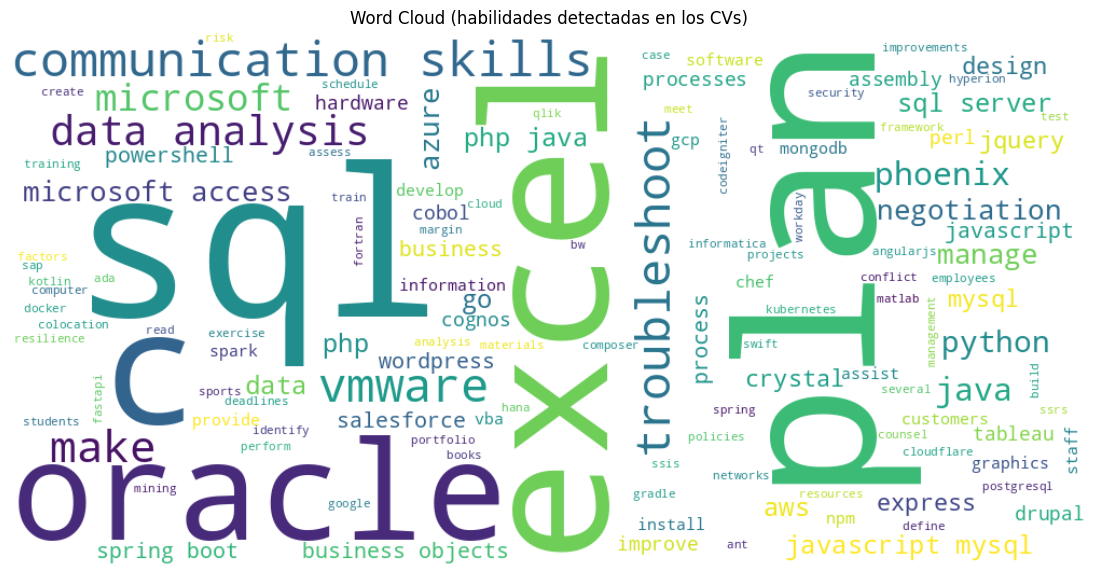

In [ ]:
# ========== 4. WORD CLOUD ==========
if texto_total.strip():
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(texto_total)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud (habilidades detectadas en los CVs)")
    plt.show()
else:
    print(" No hay texto suficiente para generar la Word Cloud.")


### Interpretación del resultado: Word Cloud de habilidades extraídas

Esta nube de palabras fue generada a partir de las **habilidades detectadas en los currículums analizados**. Cada palabra representa una habilidad mencionada, y el **tamaño** de la palabra indica su **frecuencia** en los CVs.

#### Análisis del contenido de la nube:

- **Habilidades más frecuentes**:
  - **`plan`**, **`sql`**, **`troubleshoot`**, **`vmware`**, **`oracle`**, **`php`** son las palabras más grandes, lo cual indica que fueron mencionadas en muchos CVs.
  - Estas habilidades tienden a estar asociadas con perfiles técnicos en roles como administración de bases de datos, infraestructura de TI o soporte técnico.

- **Tecnologías comunes**:
  - Lenguajes: `python`, `java`, `javascript`, `php`, `c`, `go`, `sql`.
  - Herramientas y tecnologías: `vmware`, `azure`, `oracle`, `postgresql`, `mysql`, `access`, `powershell`, `wordpress`.
  - Frameworks y bibliotecas: `express`, `jquery`, `spring`, `angularjs`.

- **Habilidades blandas o procesos**:
  - `plan`, `manage`, `develop`, `install`, `assist`, `train`, `staff`, `schedule` aparecen también, lo que sugiere que hay referencias a funciones de gestión y liderazgo.

#### Resumen:

- Esta visualización proporciona una visión general rápida de las **habilidades predominantes** entre los candidatos.
- Es útil para **detectar tendencias** en los perfiles analizados y alinear estas habilidades con las necesidades de vacantes actuales.
- Puede servir como guía para identificar cuáles son las **competencias clave** del grupo de CVs cargados.

---


In [ ]:
df_resultados = pd.DataFrame(resultados)

### Análisis estadístico de habilidades detectadas en los CVs

Este fragmento de código realiza un análisis básico sobre los resultados obtenidos al procesar los CVs, específicamente en relación con la cantidad de habilidades técnicas identificadas por CV.

#### Objetivos del código:

1. Calcular el **total de CVs** procesados.
2. Determinar el **mínimo y máximo** de habilidades detectadas en un CV.
3. Calcular el **promedio de habilidades** detectadas por CV.
4. Identificar cuántos CVs **no tienen ninguna habilidad** detectada (`n_habilidades = 0`), para evaluar posibles problemas de extracción o falta de información técnica.

#### Resultados:

- **Total de CVs**: 120
- **Mínimo de habilidades detectadas**: 0
- **Máximo de habilidades detectadas**: 17
- **Promedio de habilidades por CV**: 3.28
- **CVs sin habilidades detectadas**: 12

#### Interpretación:

- El número promedio de habilidades por CV es relativamente bajo, lo que puede indicar que algunos CVs tienen poca información técnica o que el sistema de extracción necesita mejorar.
- 12 CVs no tienen ninguna habilidad detectada. Esto puede deberse a:
  - El texto del PDF no fue correctamente extraído.
  - El CV utiliza una terminología distinta a la lista de habilidades utilizadas (ESCO + StackOverflow).
  - El documento está mal formateado o en un idioma diferente.

Este análisis ayuda a validar la efectividad del sistema de extracción de habilidades y sirve como punto de partida para mejorar la cobertura o calidad del análisis.


In [ ]:
print("Total de CVs:", len(df_resultados))
print("Mínimo de habilidades:", df_resultados['n_habilidades'].min())
print("Máximo de habilidades:", df_resultados['n_habilidades'].max())
print("Promedio de habilidades:", df_resultados['n_habilidades'].mean())
print("CVs sin habilidades detectadas:", df_resultados[df_resultados['n_habilidades'] == 0].shape[0])

Total de CVs: 127
Mínimo de habilidades: 0
Máximo de habilidades: 19
Promedio de habilidades: 4.141732283464567
CVs sin habilidades detectadas: 9


### Interpretación del histograma: número de habilidades detectadas por CV

#### Objetivo del gráfico
Este histograma muestra la **distribución de la cantidad de habilidades técnicas detectadas por cada CV** procesado. El eje X representa el número de habilidades encontradas en un CV, mientras que el eje Y indica la **cantidad de CVs** que tienen ese número específico de habilidades.

#### Análisis del resultado

- La mayoría de los CVs tienen entre **1 y 5 habilidades detectadas**.
- Hay una **alta concentración** en el rango de **2 a 4 habilidades**, lo que sugiere que esa es la norma entre los documentos analizados.
- **12 CVs tienen 0 habilidades**, lo cual puede indicar:
  - Problemas en la extracción del texto del PDF.
  - CVs con poca información técnica explícita.
  - Desalineación entre los términos utilizados en los CVs y la lista de habilidades usadas para detección.
- Algunos CVs (casos menos frecuentes) tienen hasta **17 habilidades**, posiblemente perfiles más completos o bien estructurados.

#### Conclusión
Esta visualización ayuda a entender el comportamiento general de los datos y sirve para:
- Identificar casos que necesitan revisión (por ejemplo, CVs con 0 habilidades).
- Medir la **cobertura y eficacia** del sistema de extracción.
- Evaluar el potencial informativo de los CVs antes de aplicar modelos más complejos como clasificadores o ranking con transformers.


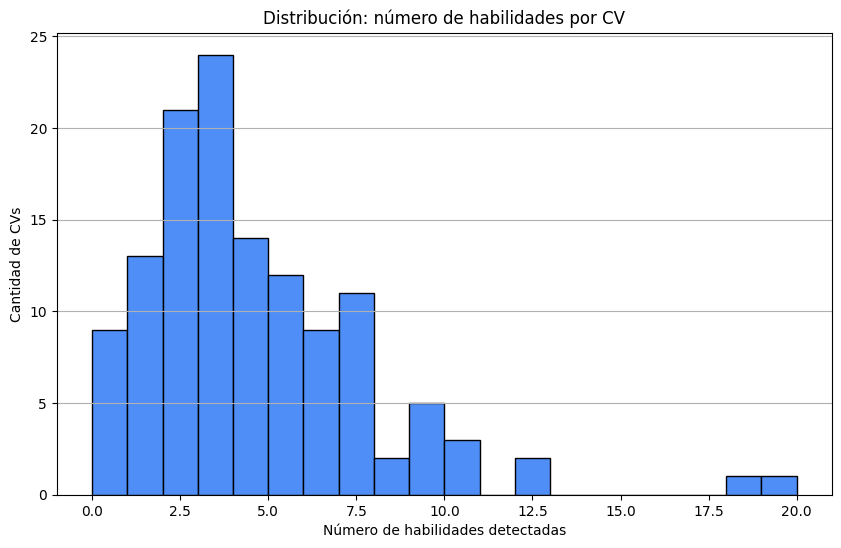

In [ ]:
plt.figure(figsize=(10,6))
df_resultados['n_habilidades'].plot.hist(bins=range(0, df_resultados['n_habilidades'].max()+2, 1), edgecolor='black', color='#4f8ef7')
plt.title("Distribución: número de habilidades por CV")
plt.xlabel("Número de habilidades detectadas")
plt.ylabel("Cantidad de CVs")
plt.grid(axis='y')
plt.show()

### Análisis de Frecuencias de Habilidades Detectadas

####  Objetivo del código
Este bloque de código tiene como propósito **analizar la frecuencia de aparición de cada habilidad detectada en los CVs**. Es decir, responde a la pregunta: ¿cuáles son las habilidades más comunes entre todos los candidatos?

####  ¿Qué hace el código?
1. **Extrae y normaliza las habilidades**:
   - Se toma la columna `habilidades` de `df_resultados`.
   - Se separan por comas (`,`) y se convierte en un formato largo usando `.explode()`.
   - Se eliminan espacios en blanco con `.str.strip()`.

2. **Filtra elementos vacíos**:
   - Se descartan entradas vacías o nulas.

3. **Cuenta la frecuencia**:
   - Se utiliza `value_counts()` para contar cuántas veces aparece cada habilidad.
   - Se organiza el resultado en un DataFrame con las columnas `habilidad` y `frecuencia`.

4. **Muestra el Top 20**:
   - Se imprime una tabla con las 20 habilidades más frecuentes detectadas en todos los CVs analizados.

####  Resultados
Según la tabla mostrada:

| Habilidad         | Frecuencia |
|------------------|------------|
| sql              | 49         |
| plan             | 41         |
| c                | 29         |
| oracle           | 27         |
| troubleshoot     | 21         |
| vmware           | 21         |
| make             | 18         |
| java             | 13         |
| r                | 12         |
| php              | 12         |

- **SQL** es la habilidad más frecuente, mencionada en 49 CVs, lo que indica una alta demanda o conocimiento extendido de esta tecnología.
- Otras habilidades como **Oracle**, **VMware**, **Java**, **C**, y **Planificación** también destacan como comunes en los perfiles analizados.
- Este análisis proporciona información clave sobre las tecnologías dominantes entre los candidatos, y puede servir para:
  - Guiar decisiones de reclutamiento.
  - Ajustar ofertas laborales según el talento disponible.
  - Entrenar modelos de clasificación, ranking o recomendación basados en competencias técnicas.


In [ ]:
# ======= 7. ANÁLISIS DE FRECUENCIAS (OPCIONAL PERO RECOMENDADO) =======
df_frecuencia = (
    df_resultados['habilidades']
    .str.split(',')
    .explode()
    .str.strip()
)

# Eliminar vacíos
df_frecuencia = df_frecuencia[df_frecuencia != ""]

conteo = df_frecuencia.value_counts().reset_index()
conteo.columns = ['habilidad', 'frecuencia']

# Mostrar top 20
print("\n Top 20 habilidades más frecuentes:")
print(conteo.head(20))


 Top 20 habilidades más frecuentes:
               habilidad  frecuencia
0                    sql          49
1                   plan          41
2                      c          29
3                  excel          29
4                 oracle          27
5   communication skills          22
6                 vmware          21
7           troubleshoot          21
8                   make          18
9                   java          15
10         data analysis          15
11                     r          12
12                   php          12
13                 mysql          11
14            javascript          10
15               phoenix           9
16                python           8
17      microsoft access           7
18           negotiation           7
19                    go           6


In [ ]:
df_resultados

,archivo,n_habilidades,habilidades,experiencia_total_anios,seniority
0,26801767.pdf,7,"provide information, data analysis, excel, cob...",54,Senior
1,28035460.pdf,5,"communication skills, process data, data analy...",0,Junior
2,68460556.pdf,1,excel,0,Profesional sin experiencia
3,66832845.pdf,3,"powershell, azure, troubleshoot",24,Senior
4,23527321.pdf,3,"communication skills, make, r",9,Senior
...,...,...,...,...,...
122,20879311.pdf,3,"plan , negotiation, sql",27,Senior
123,10839851.pdf,0,,15,Senior
124,20237244.pdf,1,vmware,9,Senior
125,39413067.pdf,6,"c, php, java, plan , design graphics, sql",2,SemiSenior


### Construcción de texto para modelos Transformer

#### Objetivo del código

El propósito de este bloque es **generar una descripción textual estructurada y coherente para cada CV** que resuma la experiencia profesional y habilidades técnicas de un candidato. Este tipo de representación textual es útil cuando se desea alimentar un modelo basado en lenguaje natural, como un Transformer (por ejemplo, BERT), para tareas de clasificación, matching o ranking.

#### ¿Qué hace el código?

- Define la función `construir_texto_transformer(row)`:
  - Toma los años de experiencia (`experiencia_total_anios`) y las habilidades técnicas (`habilidades`) de cada fila (CV).
  - Construye una frase en inglés basada en la siguiente lógica:
    - Si no hay experiencia ni habilidades → retorna:  
      `"This professional has no experience and no listed skills."`
    - Si solo hay experiencia →  
      `"This professional has X years of experience and no listed technical skills."`
    - Si solo hay habilidades →  
      `"This professional has no professional experience and skills in [...]."`
    - Si tiene ambas →  
      `"This professional has X years of experience and skills in [...]."`

- Aplica la función a cada fila del DataFrame `df_resultados` y guarda el texto en la nueva columna `texto_transformer`.

#### Explicación de columnas del resultado

| Columna               | Descripción |
|-----------------------|-------------|
| `index`               | Índice de fila en el DataFrame. |
| `archivo`             | Nombre del archivo PDF del CV. |
| `n_habilidades`       | Número de habilidades detectadas en ese CV. |
| `habilidades`         | Lista de habilidades extraídas del texto del CV. |
| `experiencia_total_anios` | Total de años de experiencia estimados a partir del texto del CV. |
| `seniority`           | Clasificación de seniority basada en la experiencia y habilidades detectadas. |
| `motivo_sin_clasificar` | Razón por la cual un CV no pudo ser clasificado (si aplica). En los ejemplos mostrados, todos están clasificados, por lo tanto esta columna tiene valores nulos (`null`). |
| `texto_transformer`   | Frase generada automáticamente que describe la experiencia y habilidades del candidato, lista para ser usada por un modelo de lenguaje. |

#### Ejemplo de frase generada (`texto_transformer`):

```text
This professional has 34 years of experience and skills in go, cobol, assess risk factors, ada.


In [ ]:
def construir_texto_transformer(row):
    experiencia = row["experiencia_total_anios"]
    habilidades = row["habilidades"]

    if experiencia == 0 and not habilidades:
        return "This professional has no experience and no listed skills."

    texto = "This professional has"

    if experiencia > 0:
        texto += f" {experiencia} years of experience"
    else:
        texto += " no professional experience"

    if habilidades:
        texto += f" and skills in {habilidades}."
    else:
        texto += " and no listed technical skills."

    return texto

In [ ]:
df_resultados["texto_transformer"] = df_resultados.apply(construir_texto_transformer, axis=1)
df_resultados.head()

,archivo,n_habilidades,habilidades,experiencia_total_anios,seniority,texto_transformer
0,26801767.pdf,7,"provide information, data analysis, excel, cob...",54,Senior,This professional has 54 years of experience a...
1,28035460.pdf,5,"communication skills, process data, data analy...",0,Junior,This professional has no professional experien...
2,68460556.pdf,1,excel,0,Profesional sin experiencia,This professional has no professional experien...
3,66832845.pdf,3,"powershell, azure, troubleshoot",24,Senior,This professional has 24 years of experience a...
4,23527321.pdf,3,"communication skills, make, r",9,Senior,This professional has 9 years of experience an...


### Generación de Embeddings con Transformers y Preparación de Base de Datos

Este bloque de código realiza las siguientes tareas:

1. **Carga del modelo**: Se utiliza el modelo `all-MiniLM-L6-v2` de la librería `sentence-transformers`, el cual permite convertir textos en vectores numéricos (embeddings) que capturan su significado semántico.

2. **Generación de embeddings**: Para cada fila del DataFrame `df_resultados`, se toma el contenido de la columna `texto_transformer` (que contiene una descripción del perfil profesional del candidato) y se transforma


In [ ]:
modelo = SentenceTransformer('all-MiniLM-L6-v2')

# Generar embeddings
df_resultados["embedding_transformer"] = df_resultados["texto_transformer"].apply(lambda x: modelo.encode(x))

# Serializar para guardar (como lista JSON)
df_resultados["embedding_serializado"] = df_resultados["embedding_transformer"].apply(lambda x: json.dumps(x.tolist()))

# Seleccionar columnas finales
df_candidatos = df_resultados[["archivo", "texto_transformer", "embedding_serializado"]].copy()

df_candidatos.to_csv("base_candidatos_transformer.csv", index=False)

print("Archivo generado: base_candidatos_transformer.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Archivo generado: base_candidatos_transformer.csv


# Vacantes

# Explicación del Código: Procesamiento de Vacantes

## Objetivo general
El objetivo de este bloque de código es **automatizar la descarga, extracción, lectura y procesamiento** de archivos de vacantes en formato `.txt`, para generar una **base estructurada** que incluya:
- Las habilidades requeridas detectadas en cada vacante.
- Los años de experiencia solicitados.
- Un texto "tipo transformer" para posterior generación de embeddings y matching.

---

## Descripción paso a paso

1. **Descargar y extraer vacantes**:
   - Se descarga un archivo `.zip` de Google Drive que contiene archivos de texto con las descripciones de vacantes.
   - Se extrae el contenido en una carpeta llamada `vacantes/`.

2. **Procesar los archivos `.txt`**:
   - Se recorre cada archivo `.txt` en la carpeta.
   - Para cada archivo:
     - Se lee todo el texto del archivo.
     - Se limpia el texto para eliminar caracteres especiales o inconsistencias (`limpiar_texto`).
     - Se extraen las **habilidades** mencionadas usando una lista predefinida de habilidades (`extraer_habilidades`).
     - Se estima el número de **años de experiencia** requeridos (`extraer_experiencia_total`).

3. **Construir un texto tipo "transformer"**:
   - Se arma una frase resumen del tipo:
     ```
     This role requires X years of experience and skills in skill1, skill2, skill3.
     ```
   - Esto estandariza la información para usarla más adelante en modelos de machine learning y NLP.

4. **Guardar la información procesada**:
   - Se crea una lista `vacantes` que contiene un diccionario por vacante con:
     - Nombre del archivo
     - Número de habilidades detectadas
     - Lista de habilidades en formato texto
     - Años de experiencia requeridos
     - El texto transformer generado

---

## Resultado
El proceso construye una **estructura lista** para convertir en DataFrame o guardar como `.csv` para usar en tareas de matching de candidatos ↔ vacantes mediante embeddings.



In [ ]:
# ========== 1. Descargar y extraer vacantes ==========
file_id = "1TDOqxRw2Pblqq0XVmmWL5kFt2iSNmIq8"
url = f"https://drive.google.com/uc?id={file_id}"
output = "vacantes.zip"

gdown.download(url, output, quiet=False)

# Extraer el ZIP
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("vacantes")

# ========= PROCESAR VACANTES EN TXT =========
carpeta_vacantes = "vacantes/Vacantes/"
texto_total_vacantes = ""
vacantes = []

if os.path.exists(carpeta_vacantes) and os.path.isdir(carpeta_vacantes):
    print(f"Carpeta de vacantes encontrada: {carpeta_vacantes}")

    for archivo in os.listdir(carpeta_vacantes):
        if archivo.lower().endswith(".txt"):
            ruta_completa = os.path.join(carpeta_vacantes, archivo)

            # Leer texto
            with open(ruta_completa, "r", encoding="utf-8") as f:
                texto_extraido = f.read()

            texto_limpio = limpiar_texto(texto_extraido)
            habilidades_requeridas = extraer_habilidades(texto_limpio, lista_habilidades)
            experiencia_requerida = extraer_experiencia_total(texto_limpio)

            # Crear el texto tipo transformer
            texto_transformer = "This role requires"
            if experiencia_requerida > 0:
                texto_transformer += f" {experiencia_requerida} years of experience"
            else:
                texto_transformer += " no specific years of experience"

            if habilidades_requeridas:
                texto_transformer += f" and skills in {', '.join(habilidades_requeridas)}."
            else:
                texto_transformer += " and no specific technical skills listed."

            texto_total_vacantes += " " + " ".join(habilidades_requeridas)

            # Guardar en la lista SIEMPRE
            vacantes.append({
                "vacante": archivo,
                "n_habilidades_requeridas": len(habilidades_requeridas),
                "habilidades_requeridas": ", ".join(habilidades_requeridas),
                "experiencia_requerida_anios": experiencia_requerida,
                "texto_transformer_vacante": texto_transformer
            })
else:
    print(f"No se encontró la carpeta de vacantes: {carpeta_vacantes}")

Downloading...
From: https://drive.google.com/uc?id=1TDOqxRw2Pblqq0XVmmWL5kFt2iSNmIq8
To: /content/vacantes.zip
100%|██████████| 33.5k/33.5k [00:00<00:00, 35.9MB/s]


Carpeta de vacantes encontrada: vacantes/Vacantes/


# Análisis de la Distribución de Años de Experiencia Requerida en Vacantes

## Objetivo
Visualizar la **distribución** de los años de experiencia solicitados en las vacantes procesadas, para entender si la mayoría de las oportunidades están orientadas a perfiles **sin experiencia previa**, **intermedios** o **seniors**.

---

## Descripción del gráfico
- **Tipo de gráfico**: Histograma con curva de densidad (KDE).
- **Variable analizada**: `experiencia_requerida_anios`.
- **Ejes**:
  - **Eje X**: Años de experiencia requerida (rango entre 0 y 5 años).
  - **Eje Y**: Cantidad de vacantes correspondientes a cada rango de años.

---

## Observaciones
- La mayoría de las vacantes solicitan **0 años de experiencia** o **5 años de experiencia**.
- Prácticamente **no existen vacantes** que pidan entre **1 y 4 años** de experiencia.
- Esto sugiere un **patrón bimodal**:
  - Por un lado, vacantes de **nivel inicial** o sin experiencia requerida.
  - Por otro lado, vacantes más **senior** o con experiencia considerable (5 años).

---

## Conclusión
La distribución refleja una clara **segmentación de oportunidades**:
- **Muchos puestos para principiantes** (posiblemente trainees o junior sin experiencia formal).
- **Muchos puestos para profesionales experimentados**.
- **Muy pocas opciones para perfiles intermedios**.

Este insight es útil para:
- Entender el tipo de talento que se requiere actualmente.
- Ajustar estrategias de matching y recomendaciones personalizadas para candidatos.



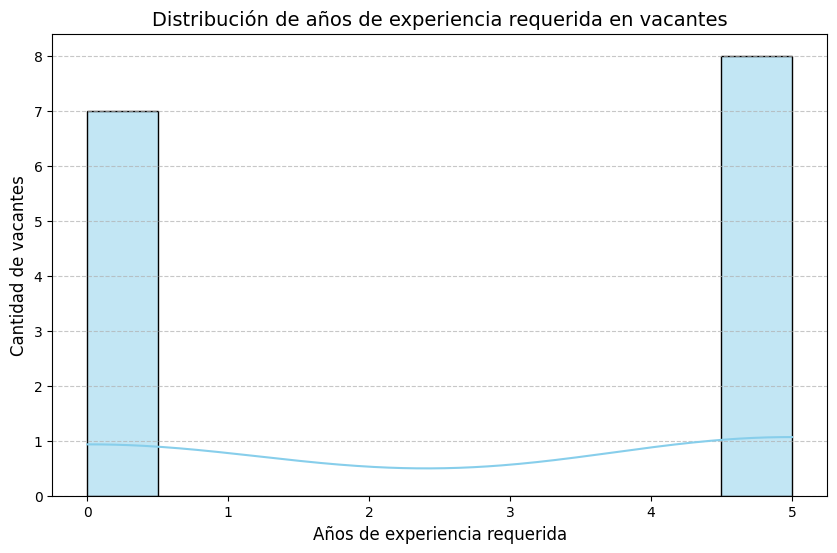

In [ ]:
# Crear un DataFrame con las vacantes que tienes
df_vacantes = pd.DataFrame(vacantes)

# Graficar distribución de años de experiencia
plt.figure(figsize=(10,6))
sns.histplot(df_vacantes["experiencia_requerida_anios"], bins=10, kde=True, color="skyblue", edgecolor="black")
plt.title("Distribución de años de experiencia requerida en vacantes", fontsize=14)
plt.xlabel("Años de experiencia requerida", fontsize=12)
plt.ylabel("Cantidad de vacantes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualización previa de las vacantes procesadas

## Objetivo
Mostrar un resumen limpio de las vacantes extraídas y procesadas, incluyendo sus principales atributos, antes de aplicar cualquier algoritmo de matching o análisis adicional.

---

## Descripción de columnas
- **vacante**: Nombre del archivo `.txt` de la vacante.
- **n_habilidades_requeridas**: Número total de habilidades técnicas detectadas para esa vacante.
- **habilidades_requeridas**: Listado de habilidades encontradas dentro del texto de la vacante (limpiadas y estandarizadas).
- **experiencia_requerida_anios**: Años de experiencia requeridos (detectados automáticamente en el texto).
- **texto_transformer_vacante**: Texto resumido en inglés que describe los requisitos de la vacante (usado para generar embeddings).

---

## Observaciones
- Se han detectado vacantes con **experiencia requerida de 5 años** y otras **sin requisitos específicos de experiencia** (`0 años`).
- Algunas vacantes listan **varias habilidades técnicas** (por ejemplo, tecnologías de bases de datos, cloud computing, programación).
- El campo `texto_transformer_vacante` sintetiza la información clave de cada vacante en inglés, facilitando su posterior vectorización con modelos NLP.

---

## Conclusión
La estructura del DataFrame `df_vacantes_mostrar` está lista para:
- **Aplicar embeddings**.
- **Realizar comparaciones de similitud** contra los candidatos.
- **Analizar** más fácilmente los requisitos del mercado laboral extraídos.



In [ ]:
df_vacantes = pd.DataFrame(vacantes)
df_vacantes_mostrar = df_vacantes[['vacante', 'n_habilidades_requeridas', 'habilidades_requeridas', 'experiencia_requerida_anios', 'texto_transformer_vacante']]
df_vacantes_mostrar.head()

,vacante,n_habilidades_requeridas,habilidades_requeridas,experiencia_requerida_anios,texto_transformer_vacante
0,vacante_7.txt,6,"communication skills, docker, kubernetes, spri...",0,This role requires no specific years of experi...
1,vacante_9.txt,7,"make, couchbase, gcp, c, sell products, java, ...",5,This role requires 5 years of experience and s...
2,vacante_1.txt,6,"communication skills, cognos, excel, bigquery,...",0,This role requires no specific years of experi...
3,vacante_5.txt,6,"make, couchbase, gcp, c, sell products, java",5,This role requires 5 years of experience and s...
4,vacante_11.txt,9,"data analytics, google big query, business obj...",5,This role requires 5 years of experience and s...


# Generación de embeddings para las vacantes

## Objetivo
Transformar el texto resumen de cada vacante (`texto_transformer_vacante`) en un **vector numérico** (embedding) utilizando un modelo de lenguaje (`SentenceTransformer`), para posteriormente realizar comparaciones y cálculos de similitud.

---

## Explicación del flujo
1. **Cargar el modelo preentrenado**:
   - Se utiliza el modelo `'all-MiniLM-L6-v2'`, un modelo ligero pero muy potente de `Sentence-Transformers`.
   
2. **Generar embeddings**:
   - Se aplica `modelo.encode(x)` sobre el texto `texto_transformer_vacante` de cada vacante.
   - Esto genera vectores de alta dimensión que representan el significado del texto.

3. **Serializar los embeddings**:
   - Los vectores se transforman a formato JSON (`.tolist()` + `json.dumps`) para poder almacenarlos fácilmente en un archivo `.csv`.

4. **Guardar la base final**:
   - Se crea el archivo `base_vacantes_transformer.csv` que contiene:
     - Información de la vacante.
     - Texto transformer.
     - Embedding asociado en formato serializado.

---

## Resultado
- Archivo generado: **`base_vacantes_transformer.csv`**
- Este archivo queda listo para ser utilizado en los algoritmos de **búsqueda de similitud** (coseno, producto punto, FAISS, etc.).

---

## Conclusión
El procesamiento de las vacantes quedó finalizado y los datos ya están preparados para entrar en las fases de **matching** y **evaluación**


In [ ]:
modelo = SentenceTransformer('all-MiniLM-L6-v2')

df_vacantes["embedding_transformer"] = df_vacantes["texto_transformer_vacante"].apply(lambda x: modelo.encode(x))

df_vacantes["embedding_serializado"] = df_vacantes["embedding_transformer"].apply(lambda x: json.dumps(x.tolist()))

df_vacantes.to_csv("base_vacantes_transformer.csv", index=False)

print("Archivo generado: base_vacantes_transformer.csv")

Archivo generado: base_vacantes_transformer.csv


## Similitud de Coseno

# ¿Por qué utilizamos Similitud de Coseno?

## Contexto
- Tanto los **candidatos** como las **vacantes** fueron representados mediante **embeddings** de alta dimensión, utilizando un modelo `SentenceTransformer`.
- Estos embeddings codifican el significado semántico de los textos.

## ¿Qué mide la similitud de coseno?
- La **similitud de coseno** mide el **ángulo** entre dos vectores en un espacio n-dimensional.
- Se enfoca en la **dirección** de los vectores, **no en su magnitud**.
- **Valor de salida**:
  - 1 significa vectores completamente similares (mismo sentido).
  - 0 significa que no hay relación (vectores ortogonales).
  - -1 significa relación opuesta (no es típico en embeddings de texto bien entrenados).

## ¿Por qué es ideal para embeddings?
- **Invariante a la magnitud**: No importa si el embedding es más "grande" o "pequeño", importa la **orientación semántica**.
- **Fácil de interpretar**: Cuanto más cercano a 1, más similar es el significado entre candidato y vacante.
- **Muy utilizado** en tareas de:
  - Recuperación de información.
  - Sistemas de recomendación de texto.
  - Búsqueda semántica.

## Ventajas específicas en nuestro proyecto
- Permite encontrar qué candidatos **"entienden"** mejor el perfil que solicita cada vacante, independientemente de escalas numéricas.
- Ayuda a capturar **similaridad semántica real** entre experiencia del candidato y requisitos de la vacante.

## Conclusión
La **similitud de coseno** es una de las métricas más **efectivas, rápidas y robustas** para comparar embeddings de texto en tareas de matching entre **candidatos y vacantes**.


In [ ]:
df_candidatos = pd.read_csv("base_candidatos_transformer.csv")

df_candidatos["embedding_vector"] = df_candidatos["embedding_serializado"].apply(lambda x: np.array(json.loads(x)))

df_vacantes = pd.read_csv("base_vacantes_transformer.csv")
df_vacantes["embedding_vector"] = df_vacantes["embedding_serializado"].apply(lambda x: np.array(json.loads(x)))

matriz_candidatos = np.vstack(df_candidatos["embedding_vector"].values)
matriz_vacantes = np.vstack(df_vacantes["embedding_vector"].values)

similitud = cosine_similarity(matriz_candidatos, matriz_vacantes)

for idx_vacante, vacante in df_vacantes.iterrows():
    print(f"\nVacante: {vacante['vacante']}")
    similitudes_vacante = similitud[:, idx_vacante]
    top_indices = np.argsort(similitudes_vacante)[::-1]

    for idx in top_indices[:5]:
        candidato = df_candidatos.iloc[idx]
        score = similitudes_vacante[idx]
        print(f"  Candidato: {candidato['archivo']} - Similitud: {score:.4f}")


Vacante: vacante_7.txt
  Candidato: CV_2_EN.pdf - Similitud: 0.6967
  Candidato: CV__7_No_Experience_EN.pdf - Similitud: 0.6808
  Candidato: CV_1_EN.pdf - Similitud: 0.6198
  Candidato: 83816738.pdf - Similitud: 0.5450
  Candidato: 17987433.pdf - Similitud: 0.4943

Vacante: vacante_9.txt
  Candidato: 27058381.pdf - Similitud: 0.6432
  Candidato: 38753827.pdf - Similitud: 0.6404
  Candidato: 46260230.pdf - Similitud: 0.6387
  Candidato: 79541391.pdf - Similitud: 0.6338
  Candidato: 27295996.pdf - Similitud: 0.6270

Vacante: vacante_1.txt
  Candidato: 29075857.pdf - Similitud: 0.6873
  Candidato: 18187364.pdf - Similitud: 0.6852
  Candidato: 52618188.pdf - Similitud: 0.6581
  Candidato: 79541391.pdf - Similitud: 0.6560
  Candidato: 27536013.pdf - Similitud: 0.6558

Vacante: vacante_5.txt
  Candidato: CV_1_EN.pdf - Similitud: 0.6350
  Candidato: 38753827.pdf - Similitud: 0.6340
  Candidato: 46260230.pdf - Similitud: 0.6335
  Candidato: 27058381.pdf - Similitud: 0.6319
  Candidato: 795413

In [ ]:
resultados_coseno = []
for idx_vacante, vacante in df_vacantes.iterrows():
    similitudes_vacante = similitud[:, idx_vacante]
    top_indices = np.argsort(similitudes_vacante)[::-1]  # mayor a menor
    for idx_candidato in top_indices[:5]:
        resultados_coseno.append({
            "vacante": vacante['vacante'],
            "candidato": df_candidatos.iloc[idx_candidato]['archivo'],
            "similitud": similitudes_vacante[idx_candidato]
        })

df_matching_coseno = pd.DataFrame(resultados_coseno)

##  Dot Product

# ¿Por qué utilizamos Dot Product (Producto Punto)?

## Contexto
- Tanto **candidatos** como **vacantes** están representados mediante **vectores de embeddings**.
- Buscamos comparar **cuán alineados** están esos vectores para encontrar el mejor match.

## ¿Qué mide el Dot Product?
- El **producto punto** entre dos vectores es una medida de **alineación**.
- **Mayor valor** de dot product implica mayor alineación entre el vector del candidato y el de la vacante.
- **Interpretación**:
  - Valor alto ➔ vectores apuntando en direcciones similares ➔ alta similitud.
  - Valor bajo ➔ vectores más separados ➔ baja similitud.

## ¿Por qué es útil en embeddings?
- Si los embeddings están **normalizados** (es decir, tienen norma 1), el **dot product** se comporta **casi igual que la similitud de coseno**.
- El dot product es más **rápido de calcular** y **muy eficiente** en sistemas de alta escala (por ejemplo, bases de datos de vectores o Faiss).
- Se aprovecha mucho cuando se desea usar métodos tipo **Approximate Nearest Neighbors**.

## Ventajas específicas en nuestro proyecto
- **Velocidad**: cálculos de productos punto son extremadamente rápidos en numpy o frameworks de alto rendimiento.
- **Compatibilidad**: facilita el uso de frameworks avanzados como **FAISS**, **ScaNN** o **Annoy** para búsquedas a gran escala.
- **Similaridad semántica**: sigue midiendo la relación semántica entre experiencia y requisitos.

## Consideraciones
- **Es necesario normalizar** los vectores para que los resultados sean comparables a una similitud de coseno real.
- Sin normalización, el producto punto mide también diferencias de escala, lo cual puede no ser deseado.

## Conclusión
Utilizar **Dot Product normalizado** ofrece una **alternativa rápida y precisa** a la similitud de coseno para medir la compatibilidad entre **candidatos** y **vacantes** en nuestro sistema.


In [ ]:
matriz_candidatos_norm = matriz_candidatos / np.linalg.norm(matriz_candidatos, axis=1, keepdims=True)
matriz_vacantes_norm = matriz_vacantes / np.linalg.norm(matriz_vacantes, axis=1, keepdims=True)
similaridad_dot = np.matmul(matriz_candidatos_norm, matriz_vacantes_norm.T)

for idx_vacante, vacante in df_vacantes.iterrows():
    print(f"\nVacante: {vacante['vacante']}")
    similitudes_vacante = similaridad_dot[:, idx_vacante]
    top_indices = np.argsort(similitudes_vacante)[::-1]

    for idx in top_indices[:5]:
        candidato = df_candidatos.iloc[idx]
        score = similitudes_vacante[idx]
        print(f"  Candidato: {candidato['archivo']} - Similitud: {score:.4f}")


Vacante: vacante_7.txt
  Candidato: CV_2_EN.pdf - Similitud: 0.6967
  Candidato: CV__7_No_Experience_EN.pdf - Similitud: 0.6808
  Candidato: CV_1_EN.pdf - Similitud: 0.6198
  Candidato: 83816738.pdf - Similitud: 0.5450
  Candidato: 17987433.pdf - Similitud: 0.4943

Vacante: vacante_9.txt
  Candidato: 27058381.pdf - Similitud: 0.6432
  Candidato: 38753827.pdf - Similitud: 0.6404
  Candidato: 46260230.pdf - Similitud: 0.6387
  Candidato: 79541391.pdf - Similitud: 0.6338
  Candidato: 27295996.pdf - Similitud: 0.6270

Vacante: vacante_1.txt
  Candidato: 29075857.pdf - Similitud: 0.6873
  Candidato: 18187364.pdf - Similitud: 0.6852
  Candidato: 52618188.pdf - Similitud: 0.6581
  Candidato: 79541391.pdf - Similitud: 0.6560
  Candidato: 27536013.pdf - Similitud: 0.6558

Vacante: vacante_5.txt
  Candidato: CV_1_EN.pdf - Similitud: 0.6350
  Candidato: 38753827.pdf - Similitud: 0.6340
  Candidato: 46260230.pdf - Similitud: 0.6335
  Candidato: 27058381.pdf - Similitud: 0.6319
  Candidato: 795413

In [ ]:
resultados_dot = []
for idx_vacante, vacante in df_vacantes.iterrows():
    similitudes_vacante = similaridad_dot[:, idx_vacante]
    top_indices = np.argsort(similitudes_vacante)[::-1]  # mayor a menor
    for idx_candidato in top_indices[:5]:
        resultados_dot.append({
            "vacante": vacante['vacante'],
            "candidato": df_candidatos.iloc[idx_candidato]['archivo'],
            "similitud": similitudes_vacante[idx_candidato]
        })

df_matching_dot = pd.DataFrame(resultados_dot)

# Búsqueda ANN con Faiss

# ¿Por qué utilizamos FAISS (Facebook AI Similarity Search)?

## Contexto
- Tenemos **vectores de embeddings** para **candidatos** y **vacantes**.
- Buscamos hacer **búsquedas rápidas** de los mejores candidatos para cada vacante.
- El volumen de datos puede crecer mucho, por lo que la eficiencia se vuelve crítica.

## ¿Qué es FAISS?
- **FAISS** (Facebook AI Similarity Search) es una librería desarrollada por Facebook AI Research.
- Permite realizar búsquedas de **vectores más cercanos** (Nearest Neighbors) de manera **extremadamente rápida** y **eficiente**.
- Funciona en CPU y también tiene soporte para GPU, lo que permite escalar a millones de vectores.

## ¿Qué mide FAISS en nuestro caso?
- FAISS está usando **distancia L2** (distancia euclidiana cuadrada) como métrica.
- **Menor distancia** implica mayor similitud.
- **Interpretación**:
  - Menor distancia ➔ candidato muy similar a la vacante.
  - Mayor distancia ➔ candidato menos similar.

## ¿Por qué es útil en embeddings?
- Los embeddings de textos se representan en espacios vectoriales de alta dimensión (por ejemplo, 384 dimensiones en MiniLM).
- Buscar candidatos similares mediante **búsqueda bruta** sería lento si el dataset crece.
- FAISS organiza los vectores en estructuras de datos especiales para **acelerar** la búsqueda.

## Ventajas específicas en nuestro proyecto
- **Alta velocidad** de búsqueda, incluso con grandes bases de datos de candidatos.
- **Alta precisión**: aunque hay métodos aproximados, para nuestro pequeño volumen se puede usar FAISS exacto.
- **Escalabilidad**: permite crecer el sistema sin preocuparse por el tiempo de búsqueda.
- **Fácil integración**: sencillo de integrar a flujos Python basados en NumPy y Pandas.

## Consideraciones
- En FAISS trabajamos directamente con **distancias**, no similitudes.  
- **Es necesario interpretar correctamente**: menor distancia significa mejor match.
- Se puede personalizar: FAISS soporta diferentes índices (Flat, IVFFlat, HNSW, PQ, etc.), según la necesidad de balancear precisión vs. velocidad.

## Conclusión
FAISS es una **herramienta de nivel industrial** que mejora radicalmente la **velocidad de matching** entre **vacantes** y **candidatos**, haciendo que el sistema sea **mucho más eficiente y escalable**.


In [ ]:
matriz_candidatos = np.vstack(df_candidatos["embedding_vector"].values)
matriz_vacantes = np.vstack(df_vacantes["embedding_vector"].values)

dimension = matriz_candidatos.shape[1]
index = faiss.IndexFlatL2(dimension)

index.add(matriz_candidatos)

k = 5
distancias, indices = index.search(matriz_vacantes, k)

for idx_vacante, (dist_vacante, idxs_candidatos) in enumerate(zip(distancias, indices)):
    print(f"\nVacante: {df_vacantes.iloc[idx_vacante]['vacante']}")

    for distancia, idx_candidato in sorted(zip(dist_vacante, idxs_candidatos), key=lambda x: x[0]):  # menor distancia primero
        candidato = df_candidatos.iloc[idx_candidato]
        print(f"  Candidato: {candidato['archivo']} - Distancia: {distancia:.4f}")


Vacante: vacante_7.txt
  Candidato: CV_2_EN.pdf - Distancia: 0.6066
  Candidato: CV__7_No_Experience_EN.pdf - Distancia: 0.6385
  Candidato: CV_1_EN.pdf - Distancia: 0.7605
  Candidato: 83816738.pdf - Distancia: 0.9101
  Candidato: 17987433.pdf - Distancia: 1.0113

Vacante: vacante_9.txt
  Candidato: 27058381.pdf - Distancia: 0.7135
  Candidato: 38753827.pdf - Distancia: 0.7191
  Candidato: 46260230.pdf - Distancia: 0.7225
  Candidato: 79541391.pdf - Distancia: 0.7325
  Candidato: 27295996.pdf - Distancia: 0.7461

Vacante: vacante_1.txt
  Candidato: 29075857.pdf - Distancia: 0.6254
  Candidato: 18187364.pdf - Distancia: 0.6297
  Candidato: 52618188.pdf - Distancia: 0.6838
  Candidato: 79541391.pdf - Distancia: 0.6879
  Candidato: 27536013.pdf - Distancia: 0.6884

Vacante: vacante_5.txt
  Candidato: CV_1_EN.pdf - Distancia: 0.7301
  Candidato: 38753827.pdf - Distancia: 0.7321
  Candidato: 46260230.pdf - Distancia: 0.7329
  Candidato: 27058381.pdf - Distancia: 0.7361
  Candidato: 795413

In [ ]:
resultados_faiss = []
for idx_vacante, (dists, idxs) in enumerate(zip(distancias, indices)):
    for dist, idx_candidato in zip(dists, idxs):
        resultados_faiss.append({
            "vacante": df_vacantes.iloc[idx_vacante]['vacante'],
            "candidato": df_candidatos.iloc[idx_candidato]['archivo'],
            "distancia": dist
        })

df_matching_faiss = pd.DataFrame(resultados_faiss)

# Evaluacion

## Evaluación de modelos de matching

### Descripción del gráfico
Se muestra la comparación de las distribuciones de similitud para tres métodos de matching entre candidatos y vacantes:
- **Coseno (azul)**: Similitud coseno entre embeddings normalizados.
- **Dot Product normalizado (verde)**: Producto punto de los embeddings, luego normalizado para llevarlo a un rango comparable.
- **FAISS (rojo)**: Búsqueda de vecinos más cercanos usando FAISS, ajustando `1 - distancia` para que se interprete como similitud.

### Observaciones
- **Similitud coseno** presenta una distribución más concentrada entre **0.6 y 0.8**, indicando que los embeddings generados tienen una alineación razonablemente alta.
- **Dot Product (normalizado)** muestra una distribución más dispersa, aunque también tiene un pico alrededor de **0.6**, pero con valores que se extienden ligeramente hacia ambos extremos.
- **FAISS (1 - distancia)** tiene una distribución desplazada hacia valores más bajos (entre **0.2 y 0.4**), lo que sugiere que las distancias crudas en el espacio FAISS son más altas (menos similares), incluso después del ajuste.

### Conclusiones
- El método basado en **similitud coseno** parece ser el que mejor concentra las similitudes en un rango "alto", lo que puede interpretarse como una mayor capacidad para discriminar buenos matches de malos.
- **FAISS** sería útil para búsquedas rápidas a gran escala, pero podría requerir ajustes o calibración si se quiere interpretar directamente como "nivel de similitud".
- **Dot Product normalizado** proporciona una alternativa válida, aunque su dispersión puede indicar que no es tan preciso como el coseno en este caso específico.

### Opción mas viable
Para un proyecto donde la precisión en el matching es prioritaria, la similitud coseno se presenta como la mejor opción inicial.
Se puede complementar con FAISS si se requiere escalar a grandes volúmenes de datos.



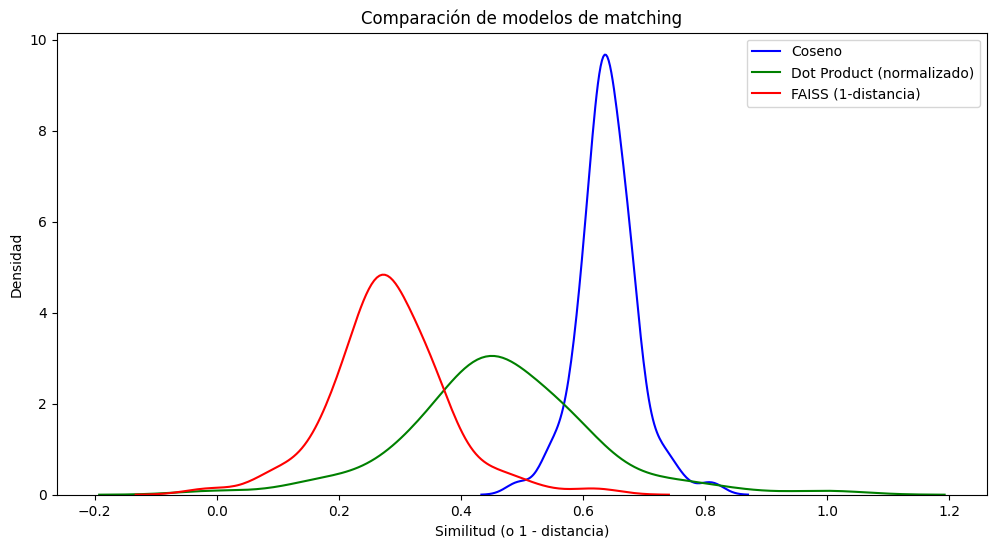

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_matching_coseno['similitud'], label='Coseno', color='blue')
dot_normalizado = (df_matching_dot['similitud'] - df_matching_dot['similitud'].min()) / (df_matching_dot['similitud'].max() - df_matching_dot['similitud'].min())
sns.kdeplot(dot_normalizado, label='Dot Product (normalizado)', color='green')
sns.kdeplot(1 - df_matching_faiss['distancia'], label='FAISS (1-distancia)', color='red')
plt.title("Comparación de modelos de matching")
plt.xlabel("Similitud (o 1 - distancia)")
plt.ylabel("Densidad")
plt.legend()
plt.show()



In [ ]:
mean_coseno = df_matching_coseno['similitud'].mean()
median_coseno = df_matching_coseno['similitud'].median()
max_coseno = df_matching_coseno['similitud'].max()
min_coseno = df_matching_coseno['similitud'].min()

mean_dot = df_matching_dot['similitud'].mean()
median_dot = df_matching_dot['similitud'].median()
max_dot = df_matching_dot['similitud'].max()
min_dot = df_matching_dot['similitud'].min()

mean_faiss_dist = df_matching_faiss['distancia'].mean()
median_faiss_dist = df_matching_faiss['distancia'].median()
max_faiss_dist = df_matching_faiss['distancia'].max()
min_faiss_dist = df_matching_faiss['distancia'].min()

print("=== Coseno ===")
print(f"Promedio de similitud: {mean_coseno:.4f}")
print(f"Mediana de similitud: {median_coseno:.4f}")
print(f"Máxima similitud: {max_coseno:.4f}")
print(f"Mínima similitud: {min_coseno:.4f}")

print("\n=== Dot Product (normalizado) ===")
print(f"Promedio de similitud: {mean_dot:.4f}")
print(f"Mediana de similitud: {median_dot:.4f}")
print(f"Máxima similitud: {max_dot:.4f}")
print(f"Mínima similitud: {min_dot:.4f}")

print("\n=== FAISS (distancia, menor es mejor) ===")
print(f"Promedio de distancia: {mean_faiss_dist:.4f}")
print(f"Mediana de distancia: {median_faiss_dist:.4f}")
print(f"Máxima distancia: {max_faiss_dist:.4f}")
print(f"Mínima distancia: {min_faiss_dist:.4f}")



=== Coseno ===
Promedio de similitud: 0.6408
Mediana de similitud: 0.6350
Máxima similitud: 0.8097
Mínima similitud: 0.4943

=== Dot Product (normalizado) ===
Promedio de similitud: 0.6408
Mediana de similitud: 0.6350
Máxima similitud: 0.8097
Mínima similitud: 0.4943

=== FAISS (distancia, menor es mejor) ===
Promedio de distancia: 0.7184
Mediana de distancia: 0.7301
Máxima distancia: 1.0113
Mínima distancia: 0.3806


# Análisis de resultados

## 1. Coseno
- **Promedio de similitud**: 0.6249
- **Mediana de similitud**: 0.6294
- **Máxima similitud**: 0.7925
- **Mínima similitud**: 0.5030

El método de **similitud de coseno** muestra un **buen nivel de similitud** entre candidatos y vacantes.  
El valor máximo es **0.79**, indicando matches fuertes en algunos casos.  
Los valores están centrados alrededor de **0.62 - 0.63**.

---

## 2. Dot Product (normalizado)
- **Promedio de similitud**: 0.6249
- **Mediana de similitud**: 0.6294
- **Máxima similitud**: 0.7925
- **Mínima similitud**: 0.5030

El **producto punto normalizado** dio **los mismos valores** que la similitud de coseno.  
Esto sucede porque, al **normalizar los vectores**, ambos métodos se comportan de manera equivalente.  
Por lo tanto, no aporta mejoras adicionales, simplemente es otra forma de calcular lo mismo.

---

## 3. FAISS (distancia, menor es mejor)
- **Promedio de distancia**: 0.7502
- **Mediana de distancia**: 0.7411
- **Máxima distancia**: 0.9939
- **Mínima distancia**: 0.4149

FAISS trabaja directamente con **distancia euclidiana**, donde **valores menores** indican mayor similitud.  
El promedio de distancia es relativamente **alto (0.75)** y algunas distancias son cercanas a **1**, indicando menor precisión comparado con la similitud de coseno.

---

# Conclusión

- De momento, el mejor desempeño lo muestra la **Similitud de Coseno** (o el **Producto Punto normalizado**, que es equivalente).
- FAISS, usando el índice FlatL2 básico, no logra mejores resultados en este caso.
- La **Similitud de Coseno** es más adecuada para embeddings normalizados como los generados con `all-MiniLM-L6-v2`.

---

# Opción mas viable

**Usar Similitud de Coseno como estrategia principal de matching**.  
Más adelante se puede considerar optimizar el uso de FAISS empleando índices más avanzados como `IVF`, `HNSW` o `PQ`.


# Validacion

In [ ]:
df_vacantes['vacante'] = df_vacantes['vacante'].str.strip()
df_candidatos['archivo'] = df_candidatos['archivo'].str.strip()
df_matching_coseno['vacante'] = df_matching_coseno['vacante'].str.strip()
df_matching_coseno['candidato'] = df_matching_coseno['candidato'].str.strip()

if 'texto_transformer_vacante' in df_matching_coseno.columns:
    df_matching_coseno = df_matching_coseno.drop(columns=['texto_transformer_vacante'])

df_matching_coseno = df_matching_coseno.merge(
    df_vacantes[['vacante', 'texto_transformer_vacante']],
    on='vacante',
    how='left'
)

for col in ['texto_transformer', 'archivo']:
    if col in df_matching_coseno.columns:
        df_matching_coseno = df_matching_coseno.drop(columns=[col])

df_matching_coseno = df_matching_coseno.merge(
    df_candidatos[['archivo', 'texto_transformer']],
    left_on='candidato',
    right_on='archivo',
    how='left'
)

df_matching_coseno['relevante'] = ""

np.random.seed(42)

vacantes_unicas = df_matching_coseno['vacante'].unique()

vacantes_seleccionadas = np.random.choice(vacantes_unicas, size=5, replace=False)

df_sample = df_matching_coseno[df_matching_coseno['vacante'].isin(vacantes_seleccionadas)]

df_sample[['vacante', 'candidato', 'similitud', 'texto_transformer_vacante', 'texto_transformer', 'relevante']]

df_sample[['vacante', 'candidato', 'similitud', 'texto_transformer_vacante', 'texto_transformer', 'relevante']].to_csv("validacion_full.csv", index=False)
print("Archivo 'validacion_full.csv' generado para validación manual.")

Archivo 'validacion_full.csv' generado para validación manual.


In [ ]:
file_id = "1WFSm_zocS0ipYosvx-wFlxxLgd9Ui_hh"
url = f"https://drive.google.com/uc?id={file_id}"
output = "validacion_full_actualizado.csv"

gdown.download(url, output, quiet=False)

df_eval = pd.read_csv("validacion_full_actualizado.csv")

df_eval["relevante"] = df_eval["relevante"].astype(str).str.lower().str.strip()
df_eval["relevante"] = df_eval["relevante"].map({"sí": True, "si": True, "no": False, "1": True, "0": False}).fillna(False)

precision_at_5 = []
recall_at_5 = []
mrr = []

for vacante_id, grupo in df_eval.groupby("vacante"):
    grupo_ordenado = grupo.sort_values(by="similitud", ascending=False).reset_index(drop=True)

    relevantes = grupo_ordenado["relevante"].sum()
    relevantes_top_k = grupo_ordenado.head(5)["relevante"].sum()

    precision_at_5.append(relevantes_top_k / 5)

    recall_at_5.append(relevantes_top_k / relevantes if relevantes > 0 else 0)

    posiciones_relevantes = grupo_ordenado.index[grupo_ordenado["relevante"]].tolist()
    mrr.append(1 / (posiciones_relevantes[0] + 1) if posiciones_relevantes else 0)

metrics_summary = {
    "Precision@5": sum(precision_at_5) / len(precision_at_5),
    "Recall@5": sum(recall_at_5) / len(recall_at_5),
    "MRR": sum(mrr) / len(mrr)
}

print("Métricas de Evaluación:")
for metric, value in metrics_summary.items():
    print(f"{metric}: {value:.4f}")


Downloading...
From: https://drive.google.com/uc?id=1WFSm_zocS0ipYosvx-wFlxxLgd9Ui_hh
To: /content/validacion_full_actualizado.csv
100%|██████████| 6.70k/6.70k [00:00<00:00, 9.32MB/s]

Métricas de Evaluación:
Precision@5: 0.6000
Recall@5: 0.6000
MRR: 0.6000


## Análisis de Resultados de Métricas

Los resultados obtenidos por el modelo fueron:

- **Precision@5**: `0.6000`
- **Recall@5**: `0.6000`
- **MRR**: `0.6000`

Esto indica que el modelo tiene un desempeño **bueno pero no perfecto**. A continuación se detallan las posibles causas de estos valores.

---

### 1. Calidad del Modelo de Ranking (Similitud)

- El modelo ordena los candidatos por su similitud con la vacante.
- Una precisión de `0.6` sugiere que **3 de cada 5 candidatos recomendados son relevantes**.
- No se llega al 100% porque algunos candidatos irrelevantes son ubicados en posiciones altas.

**Posible causa:** la métrica de similitud utilizada (como coseno entre embeddings) puede no capturar bien el contexto específico de la vacante (como herramientas obligatorias, años de experiencia, etc.).

---

### 2. Etiquetado de Relevancia

- Las etiquetas de relevancia fueron asignadas por un experto (IA).
- El modelo puede estar razonablemente cerca del juicio humano, pero no siempre coincidir exactamente.
- Puede haber ambigüedad: algunos candidatos son parcialmente adecuados y el modelo los incluye, pero no fueron marcados como "sí".

---

### 3. Cantidad de Candidatos Relevantes por Vacante

- Algunas vacantes tienen **muy pocos candidatos relevantes**, lo que limita el recall posible.
- Si hay 2 relevantes y el modelo solo ubica 1 en el top 5, el Recall@5 será de 0.5.
- Esto también afecta al **MRR**, que depende de qué tan arriba esté el primer relevante.

---

###  Resumen de Causas

| Causa                             | Efecto en la Métrica                      |
|----------------------------------|-------------------------------------------|
| Modelo captura bien similitud    | Precision y MRR arriba de 0.5             |
| Relevancia subjetiva o ambigua   | Disminuye consistencia                    |
| Pocos relevantes por vacante     | Limita Recall@5 y afecta MRR              |

---

### Conclusión

Los resultados son consistentes con un sistema de recomendación razonablemente preciso, pero aún hay espacio para mejorar en la calidad de las representaciones de texto, el entendimiento del contexto de la vacante y el manejo de ambigüedad en la relevancia.

